In [4]:
import pandas as pd
import tools.config as config
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import math

import tools.config as config
sns.set_theme(
    style="white",
    palette=None,
    rc={
        'font.family': 'Arial',
        'font.size': 12,            # 全局默认字体大小
        'axes.titlesize': 12,       # 子图标题
        'axes.labelsize': 12,       # x/y 轴标签
        'xtick.labelsize': 12,      # 刻度标签
        'ytick.labelsize': 12,      # 刻度标签
        'legend.fontsize': 12,      # 图例文字
        'figure.titlesize': 12,     # suptitle（如果你有的话）

        "mathtext.fontset": "custom",
        "mathtext.rm":      "Arial",
        "mathtext.it":      "Arial:italic",
        "mathtext.bf":      "Arial:italic",

        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 5,   # 刻度长度可选
        "ytick.major.size": 5,
    }
)

In [5]:
def analyze_masked_arrays_by_path(years, arr_path, arr1_name, arr2_name, percentiles=[99, 98, 97, 96, 95]):
    stats = []
    arr_dict = {}

    for year in years:
        arr1_path = os.path.join(arr_path, f"{arr1_name}_{year}.npy")
        arr2_path = os.path.join(arr_path, f"{arr2_name}_{year}.npy")

        arr1 = np.load(arr1_path)
        arr2 = np.load(arr2_path)

        mask = arr2 > 1
        masked_arr1 = np.where(mask, arr1, np.nan)
        arr_dict[year] = masked_arr1

        year_stats = {"Year": year}
        for p in percentiles:
            year_stats[f"{p}%"] = np.nanpercentile(masked_arr1, p)

        stats.append(year_stats)

    return pd.DataFrame(stats).set_index("Year"), arr_dict

In [215]:
years = list(range(2025, 2051))
arr_path = f"{config.TASK_DIR}/carbon_price/data"

percentile = list(range(90, 100))
df_carbon,cp_arrs = analyze_masked_arrays_by_path(years, arr_path, "carbon_price", "ghg",percentile)
df_carbon.to_excel(f"{config.TASK_DIR}/carbon_price/excel/05_uniform_carbon_price.xlsx")
df_bio,bp_arrs = analyze_masked_arrays_by_path(years, arr_path, "bio_price", "bio",percentile)
df_bio.to_excel(f"{config.TASK_DIR}/carbon_price/excel/05_uniform_bio_price.xlsx")


In [216]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import re

# 设置全局字体为Arial
plt.rcParams['font.family'] = 'Arial'


def _format_label_with_scripts(label_text):
    """
    将标签文本转换为支持上标和下标的格式
    
    规则：
    - 数字后跟e会被转为下标（如CO2 -> CO₂）
    - 负号开头的数字会被转为上标（如-1 -> ⁻¹）
    
    Parameters:
    -----------
    label_text : str
        原始标签文本
        
    Returns:
    --------
    str : 格式化后的标签文本，使用Unicode上下标字符
    """
    # 下标映射
    subscript_map = {
        '0': '₀', '1': '₁', '2': '₂', '3': '₃', '4': '₄',
        '5': '₅', '6': '₆', '7': '₇', '8': '₈', '9': '₉'
    }
    
    # 上标映射
    superscript_map = {
        '0': '⁰', '1': '¹', '2': '²', '3': '³', '4': '⁴',
        '5': '⁵', '6': '⁶', '7': '⁷', '8': '⁸', '9': '⁹',
        '-': '⁻', '+': '⁺'
    }
    
    result = label_text
    
    # 处理下标：查找紧跟在字母后的数字（如CO2中的2）
    result = re.sub(r'([A-Za-z])(\d+)', lambda m: m.group(1) + ''.join(subscript_map.get(d, d) for d in m.group(2)), result)
    
    # 处理上标：查找e后面的负数或正数（如e-1中的-1）
    result = re.sub(r'e([-+]?\d+)', lambda m: ''.join(superscript_map.get(c, c) for c in m.group(1)), result)
    
    return result


def draw_dual_y_plot(df, y_label='Value', line_color='#58abc1', area_color='#c4e4f4', 
                     other_color='#ACACAC', ylims=None, ratio=(3, 1), ax=None, 
                     clip_fill=True):
    """
    绘制双Y轴图表，显示数据分布和统计信息
    
    Parameters:
    -----------
    df : pd.DataFrame
        输入数据框
    y_label : str
        Y轴标签，支持上下标格式和LaTeX格式
    line_color : str
        中位数线颜色
    area_color : str
        四分位数区间填充颜色
    other_color : str
        其他数据线颜色
    ylims : tuple or list
        Y轴范围，格式为 ((下图下限, 下图上限), (上图下限, 上图上限))
    ratio : tuple
        上下图高度比例
    ax : matplotlib.axes or tuple
        外部提供的axes对象，用于子图绘制
    clip_fill : bool
        是否裁剪填充区域，避免遮挡轴线
    """
    # 格式化y轴标签，支持上下标（如果不是LaTeX格式）
    if not (y_label.startswith('$') and y_label.endswith('$')):
        formatted_y_label = _format_label_with_scripts(y_label)
    else:
        formatted_y_label = y_label
    
    # 计算统计量
    median = df.median(axis=1)
    q25 = df.quantile(0.25, axis=1)
    q75 = df.quantile(0.75, axis=1)
    
    # 单图模式
    if ylims is None or len(ylims) < 2:
        return _draw_single_plot(df, median, q25, q75, formatted_y_label, 
                               line_color, area_color, other_color, ax, clip_fill)
    
    # 双图模式
    return _draw_dual_plot(df, median, q25, q75, formatted_y_label, 
                          line_color, area_color, other_color, ylims, ratio, ax, clip_fill)


def draw_combined_plots(df_left, df_right, y_label_left, y_label_right, 
                       left_params=None, right_params=None, figsize=(18, 7)):
    """
    在一张图上绘制两个子图（左右布局）
    
    Parameters:
    -----------
    df_left : pd.DataFrame
        左侧图表数据
    df_right : pd.DataFrame
        右侧图表数据
    y_label_left : str
        左侧Y轴标签
    y_label_right : str
        右侧Y轴标签
    left_params : dict
        左侧图表参数
    right_params : dict
        右侧图表参数
    figsize : tuple
        图表尺寸
    """
    # 设置默认参数
    left_params = left_params or {}
    right_params = right_params or {}
    
    fig = plt.figure(figsize=figsize)
    
    # 创建左右子图布局
    gs_main = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.25)
    
    # 左侧图表
    left_ylims = left_params.get('ylims')
    if left_ylims and len(left_ylims) >= 2:
        # 双轴模式
        gs_left = gs_main[0].subgridspec(2, 1, height_ratios=left_params.get('ratio', (3, 1))[::-1], hspace=0.02)
        ax_left_top = fig.add_subplot(gs_left[0])
        ax_left_bottom = fig.add_subplot(gs_left[1], sharex=ax_left_top)
        left_axes = (ax_left_top, ax_left_bottom)
    else:
        # 单轴模式
        left_axes = fig.add_subplot(gs_main[0])
    
    # 右侧图表
    right_ylims = right_params.get('ylims')
    if right_ylims and len(right_ylims) >= 2:
        # 双轴模式
        gs_right = gs_main[1].subgridspec(2, 1, height_ratios=right_params.get('ratio', (3, 1))[::-1], hspace=0.02)
        ax_right_top = fig.add_subplot(gs_right[0])
        ax_right_bottom = fig.add_subplot(gs_right[1], sharex=ax_right_top)
        right_axes = (ax_right_top, ax_right_bottom)
    else:
        # 单轴模式
        right_axes = fig.add_subplot(gs_main[1])
    
    # 绘制左侧图表
    left_fig, left_ax = draw_dual_y_plot(df_left, y_label=y_label_left, ax=left_axes, **left_params)
    
    # 绘制右侧图表
    right_fig, right_ax = draw_dual_y_plot(df_right, y_label=y_label_right, ax=right_axes, **right_params)
    
    # 为左侧双轴图表添加居中的Y轴标签
    if isinstance(left_axes, tuple) and len(left_axes) == 2:
        # 计算两个子图的总高度中心位置
        ax_top_pos = left_axes[0].get_position()
        ax_bottom_pos = left_axes[1].get_position()
        center_y = (ax_top_pos.y0 + ax_top_pos.y1 + ax_bottom_pos.y0 + ax_bottom_pos.y1) / 2
        
        # 清除单独设置的Y轴标签
        left_axes[0].set_ylabel('')
        
        # 在中心位置添加Y轴标签
        fig.text(0.09, 0.5, y_label_left,
                 va='center', ha='center', rotation='vertical',
                  fontfamily='Arial')
    
    # 为右侧图表设置Y轴标签（如果是双轴的话也居中）
    if isinstance(right_axes, tuple) and len(right_axes) == 2:
        # 计算两个子图的总高度中心位置
        ax_top_pos = right_axes[0].get_position()
        ax_bottom_pos = right_axes[1].get_position()
        center_y = (ax_top_pos.y0 + ax_top_pos.y1 + ax_bottom_pos.y0 + ax_bottom_pos.y1) / 2
        
        # 清除单独设置的Y轴标签
        right_axes[0].set_ylabel('')
        
        # 获取右侧图表的左边界位置
        right_left_pos = ax_top_pos.x0 - 0.08
        
        # 在中心位置添加Y轴标签
        fig.text(right_left_pos, center_y, y_label_right, va='center', rotation='vertical', 
                 fontfamily='Arial')
    
    plt.show()
    return fig, (left_axes, right_axes)


def _draw_single_plot(df, median, q25, q75, y_label, line_color, area_color, 
                     other_color, ax=None, clip_fill=True):
    """绘制单一图表"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
        show_plot = True
    else:
        fig = ax.figure
        show_plot = False
    
    # 绘制所有数据线
    _plot_data_lines(ax, df, other_color)
    
    # 绘制统计信息（注意绘制顺序和裁剪）
    fill = ax.fill_between(df.index, q25, q75, color=area_color, alpha=0.6, 
                          label='25%-75%', zorder=5)
    if clip_fill:
        # 裁剪填充区域，避免超出轴范围
        fill.set_clip_box(ax.bbox)
        
    ax.plot(df.index, median, color=line_color, label='Median', linewidth=2, zorder=10)
    
    # 添加标签（智能避免重叠）
    _add_smart_labels(ax, df, other_color, single_plot=True)
    
    # 设置图表属性
    ax.set_ylabel(y_label, fontfamily='Arial')
    ax.set_xlabel('')
    ax.set_xlim(df.index[0], df.index[-1])
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # 确保轴线在最上层
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_zorder(20)
    
    if show_plot:
        plt.tight_layout()
        plt.show()
    
    return fig, ax


def _draw_dual_plot(df, median, q25, q75, y_label, line_color, area_color, 
                   other_color, ylims, ratio, ax=None, clip_fill=True):
    """绘制双Y轴断裂图表"""
    if ax is None:
        fig = plt.figure(figsize=(7, 6))
        gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=ratio[::-1], hspace=0.02)
        ax_top = fig.add_subplot(gs[0])
        ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
        show_plot = True
    else:
        if isinstance(ax, tuple) and len(ax) == 2:
            ax_top, ax_bottom = ax
            fig = ax_top.figure
        else:
            raise ValueError("双轴模式需要提供两个axes对象的元组")
        show_plot = False
    
    # 绘制上图
    _plot_data_lines(ax_top, df, other_color)
    fill_top = ax_top.fill_between(df.index, q25, q75, color=area_color, alpha=0.6, 
                                  label='25%-75%', zorder=5)
    if clip_fill:
        fill_top.set_clip_box(ax_top.bbox)
        
    ax_top.plot(df.index, median, color=line_color, label='Median', linewidth=2, zorder=10)
    ax_top.set_ylim(*ylims[1])
    ax_top.grid(True, alpha=0.3)
    
    # 绘制下图（强调样式）
    _plot_data_lines(ax_bottom, df, other_color)
    fill_bottom = ax_bottom.fill_between(df.index, q25, q75, color=area_color, alpha=0.6, zorder=5)
    if clip_fill:
        fill_bottom.set_clip_box(ax_bottom.bbox)
        
    ax_bottom.plot(df.index, median, 
                  linestyle='-', marker='o', markersize=4, linewidth=2,
                  color=line_color, zorder=10)
    ax_bottom.set_ylim(*ylims[0])
    ax_bottom.grid(True, alpha=0.3)
    
    # 设置图表样式
    _configure_dual_plot_style(ax_top, ax_bottom, df)
    
    # 添加断裂符号（完全不显示标签）
    _add_break_symbols_clean(ax_top, ax_bottom)
    
    # 添加智能标签
    _add_smart_labels(ax_top, df, other_color, upper_plot=True, ylims=ylims[1])
    _add_smart_labels(ax_bottom, df, other_color, upper_plot=False, ylims=ylims[0])
    
    # 确保轴线在最上层
    for ax_curr in [ax_top, ax_bottom]:
        ax_curr.set_axisbelow(True)
        for spine in ax_curr.spines.values():
            spine.set_zorder(20)
    
    # 设置标签和图例
    if show_plot:
        fig.text(0.1, 0.5, y_label, va='center', rotation='vertical', 
                 fontfamily='Arial')
        plt.subplots_adjust(left=0.12, right=0.95)
    else:
        # 子图模式，暂时不设置标签（由外部函数统一处理）
        pass
    
    ax_top.legend(loc='upper left', framealpha=0.9)
    
    if show_plot:
        plt.tight_layout()
        plt.show()
    
    return fig, (ax_top, ax_bottom)


def _plot_data_lines(ax, df, color):
    """绘制数据线"""
    for col in df.columns:
        ax.plot(df.index, df[col], color=color, alpha=0.8, linewidth=1, zorder=1)


def _add_smart_labels(ax, df, color, single_plot=False, upper_plot=None, ylims=None):
    """智能添加标签，避免重叠"""
    if len(df.columns) == 0:
        return
    
    # 获取最后一个数据点的值和位置
    x_end = df.index[-1]
    end_values = [(col, df[col].iloc[-1]) for col in df.columns]
    
    # 按y值排序
    end_values.sort(key=lambda x: x[1])
    
    # 计算标签位置偏移，减少偏移量避免超出图表范围
    x_range = df.index[-1] - df.index[0]
    x_offset = x_range * 0.01  # 减少偏移量
    
    # 如果有ylims，根据图的范围调整
    if ylims:
        y_range = ylims[1] - ylims[0]
        min_spacing = y_range * 0.04  # 减少最小间距
    else:
        y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
        min_spacing = y_range * 0.04
    
    # 调整标签位置避免重叠
    adjusted_positions = []
    for i, (col, y_val) in enumerate(end_values):
        adjusted_y = y_val
        
        # 检查与之前标签的距离
        for prev_y in adjusted_positions:
            if abs(adjusted_y - prev_y) < min_spacing:
                # 如果太近，向上调整
                adjusted_y = prev_y + min_spacing
        
        adjusted_positions.append(adjusted_y)
        
        # 确保标签在图的范围内
        if ylims:
            adjusted_y = max(ylims[0], min(ylims[1], adjusted_y))
        
        # 添加标签，使用较小的偏移量
        ax.annotate(col, 
                   xy=(x_end, y_val),
                   xytext=(x_end + x_offset, adjusted_y),
                   va='center', ha='left', 
                   color=color, alpha=0.9, fontfamily='Arial',
                   arrowprops=dict(arrowstyle='-', color=color, alpha=0.6, lw=0.5) 
                   if abs(adjusted_y - y_val) > min_spacing/2 else None,
                   clip_on=False)  # 允许标签在轴外显示


def _configure_dual_plot_style(ax_top, ax_bottom, df):
    """配置双图样式"""
    # 设置X轴范围
    x_range = (df.index[0], df.index[-1])
    ax_top.set_xlim(*x_range)
    ax_bottom.set_xlim(*x_range)
    
    # 隐藏连接处的边框
    ax_top.spines['bottom'].set_visible(False)
    ax_bottom.spines['top'].set_visible(False)
    
    # 设置刻度
    ax_top.tick_params(labelbottom=False, axis='x')
    ax_top.tick_params(axis='y', left=True, direction='out', length=5, width=1)
    ax_bottom.tick_params(axis='x', bottom=True, direction='out', length=5, width=1)
    ax_bottom.tick_params(axis='y', left=True, direction='out', length=5, width=1)
    
    ax_bottom.set_xlabel("")


def _add_break_symbols_clean(ax_top, ax_bottom):
    """添加断裂符号，完全避免任何标签显示"""
    d = 0.012
    
    # 创建断裂线，使用transform确保位置正确
    line1 = plt.Line2D((-d, +d), (1-d, 1+d), transform=ax_bottom.transAxes, 
                       color='k', clip_on=False, linewidth=1.5, zorder=25)
    line2 = plt.Line2D((1-d, 1+d), (1-d, 1+d), transform=ax_bottom.transAxes, 
                       color='k', clip_on=False, linewidth=1.5, zorder=25)
    
    # 上图底部的断裂符号  
    line3 = plt.Line2D((-d, +d), (-d, +d), transform=ax_top.transAxes, 
                       color='k', clip_on=False, linewidth=1.5, zorder=25)
    line4 = plt.Line2D((1-d, 1+d), (-d, +d), transform=ax_top.transAxes, 
                       color='k', clip_on=False, linewidth=1.5, zorder=25)
    
    # 直接添加到轴上，避免通过plot方法
    ax_bottom.add_line(line1)
    ax_bottom.add_line(line2)
    ax_top.add_line(line3)
    ax_top.add_line(line4)



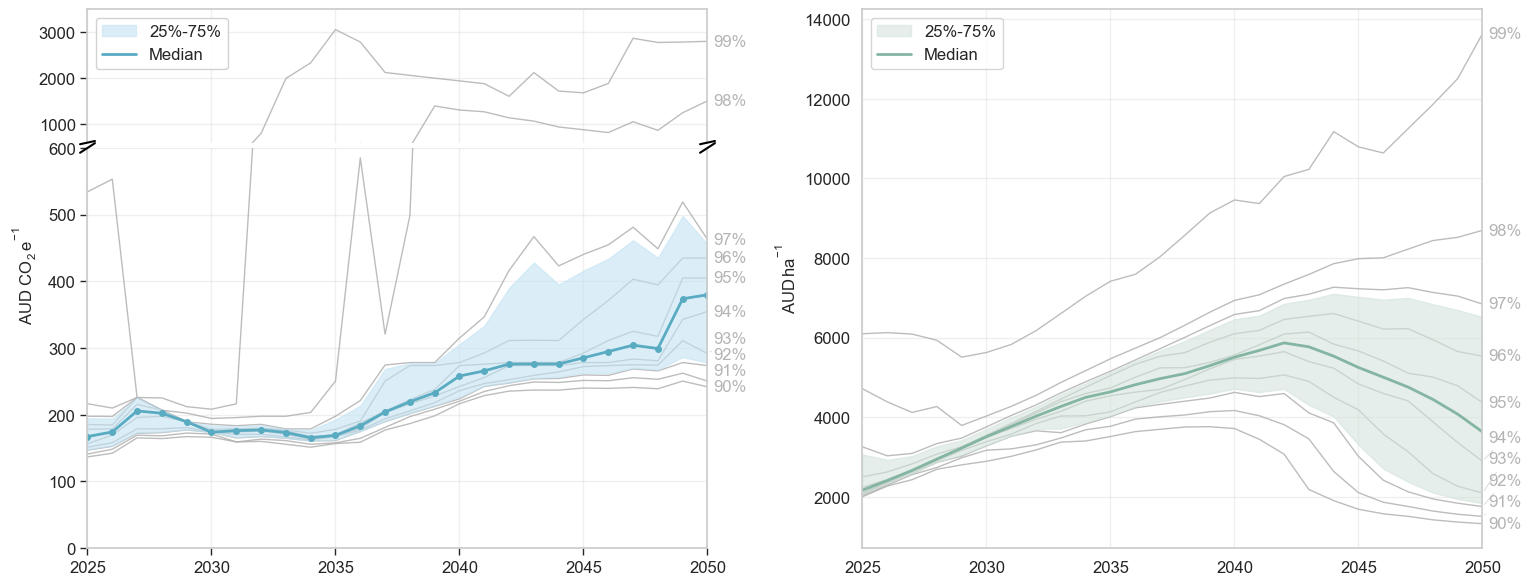

(<Figure size 1800x700 with 3 Axes>,
 ((<Axes: >, <Axes: >), <Axes: ylabel='AUD$\\,\\mathrm{ha}^{-1}$'>))

In [217]:
left_params = {
        'ylims': ((0, 600), (600, 3500)),
        'ratio': (3, 1),
        'line_color': '#58abc1',
        'area_color': '#c4e4f4',
        'other_color': '#ACACAC'
    }
    
right_params = {
    'ylims': None,
    'ratio': (3, 1),
    'line_color': '#84b5a2',
    'area_color': '#d4e4dc',
    'other_color': '#ACACAC'
}

draw_combined_plots(
    df_carbon, df_bio,
    y_label_left=r"AUD$\ \mathrm{CO}_{2}\,\mathrm{e}^{-1}$",
    y_label_right=r"AUD$\,\mathrm{ha}^{-1}$",
    left_params=left_params,
    right_params=right_params
)